Normalization constant: 0.8961693036944771
  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: -0.08152940735966657
        x: [ 9.472e-02]
      nit: 4
      jac: [ 3.425e-06]
 hess_inv: [[ 2.611e-01]]
     nfev: 12
     njev: 6
Laplace approximation - Mean: 0.09471809874520941 Variance: 0.26112105562023596


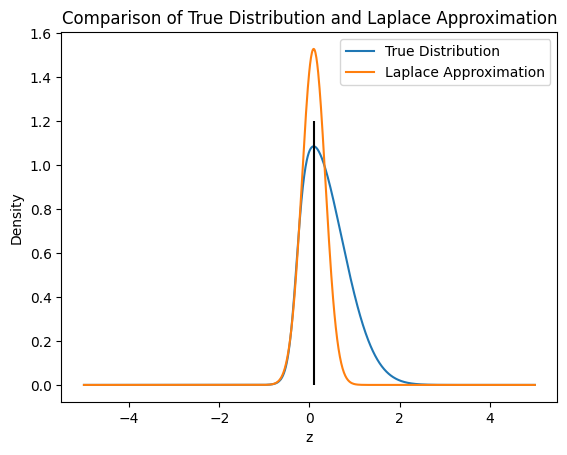

In [82]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import minimize

def sigmoid(x):
    return 1/(1+np.exp(-x))
# Define the function p(z)
def p_z(z):
    #return np.exp(-z**2/2)*sigmoid(20*z+4)
    return np.exp(-z**2) * sigmoid(10*z + 3)

# Gauss-Hermite quadrature function
def gauss_hermite_quad( f, degree):
    '''
    Calculate the integral (1) numerically.
    :param f: target function, takes a array as input x = [x0, x1,...,xn], and return a array of function values f(x) = [f(x0),f(x1), ..., f(xn)]
    :param degree: integer, >=1, number of points
    :return:
    '''

    points, weights = np.polynomial.hermite.hermgauss( degree)

    #function values at given points
    f_x = f( points)

    #weighted sum of function values
    F = np.sum( f_x  * weights)

    return F

# Calculate the normalization constant using Gauss-Hermite quadrature
normalization_constant = gauss_hermite_quad(p_z, 50)
print("Normalization constant:", normalization_constant)

# Define the Laplace approximation of p(z)
def laplace_approximation(z, mean, sd):
    return norm.pdf(z, loc=mean, scale=sd)
    #return np.exp(-(z - mean)**2 / (2 * variance)) / np.sqrt(2 * np.pi * variance)

# Define the negative log posterior function for optimization
def neg_log_posterior(z):
    return -(np.log(p_z(z)) - np.log(normalization_constant))

# Find mean and variance using Laplace approximation
result = minimize(neg_log_posterior, x0=0)
print(result)
mean = result.x[0]
variance = result.hess_inv[0, 0]
print("Laplace approximation - Mean:", mean, "Variance:", variance)

# Plotting
z_range = np.linspace(-5, 5, 1000)
plt.plot(z_range, p_z(z_range) / normalization_constant, label="True Distribution")

laplace_density = laplace_approximation(z_range, mean=mean, sd=variance)
plt.plot(z_range, laplace_density, label="Laplace Approximation")

plt.vlines(mean, ymin=0, ymax=1.2, colors='k')

plt.xlabel("z")
plt.ylabel("Density")
plt.title("Comparison of True Distribution and Laplace Approximation")
plt.legend()
plt.show()


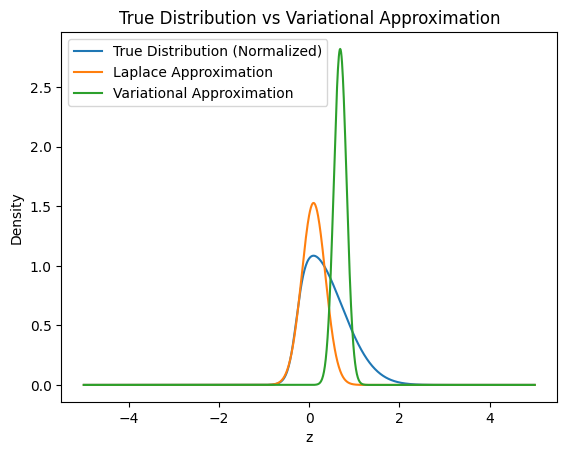

In [88]:


# Define the approximate distribution function
def q_z(z, mu, sigma_sq):
    q = (np.exp(-(z - mu)**2 / (2 * sigma_sq)) / np.sqrt(2 * np.pi * sigma_sq))#*p_z(z)
    #q /= sum(q)
    return q

# Function to compute the E-step
def compute_E_step(mu, sigma_sq):
    # Compute the expected value of -z^2
    expected_z_sq = (mu**2 + sigma_sq)
    
    # Compute the expected value of log(sigma(10z + 3))
    z_mean = mu
    log_sigma_10z_3 = np.log(1 + np.exp(-(10 * z_mean + 3))) + np.maximum(0, (10 * z_mean + 3))
    
    return expected_z_sq, log_sigma_10z_3

# Function to update parameters in the M-step
def update_M_step(expected_z_sq, log_sigma_10z_3):
    # Update mu
    mu = 5 * (log_sigma_10z_3 - 3) / (1 + 100 * expected_z_sq)
    
    # Update sigma_sq
    sigma_sq = 1 / (1 + 100 * expected_z_sq)
    
    return mu, sigma_sq

# Initialize mu and sigma_sq for variational approximation
mu_var = 0
sigma_sq_var = 1

# Number of iterations for EM-style updates
num_iter_var = 1000
mu_var_list = [mu_var]
sigma_sq_var_list = [sigma_sq_var]

# EM-style updates for variational approximation
for i in range(num_iter_var):
    # E-step
    expected_z_sq_var, log_sigma_10z_3_var = compute_E_step(mu_var, sigma_sq_var)
    
    # M-step
    mu_var, sigma_sq_var = update_M_step(expected_z_sq_var, log_sigma_10z_3_var)
    
    # Store updated mu and sigma_sq for variational approximation
    mu_var_list.append(mu_var)
    sigma_sq_var_list.append(sigma_sq_var)

# Generate points for plotting the density curves
z_values = np.linspace(-5, 5, 1000)
p_values = np.exp(-z_values**2) * sigmoid(10*z_values + 3) / normalization_constant
q_values = q_z(z_values, mu_var_list[-1], sigma_sq_var_list[-1])

# Plot the density curves
plt.plot(z_values, p_values, label='True Distribution (Normalized)')
plt.plot(z_range, laplace_density, label="Laplace Approximation")
plt.plot(z_values, q_values, label='Variational Approximation')

plt.xlabel('z')
plt.ylabel('Density')
plt.title('True Distribution vs Variational Approximation')
plt.legend()
plt.show()


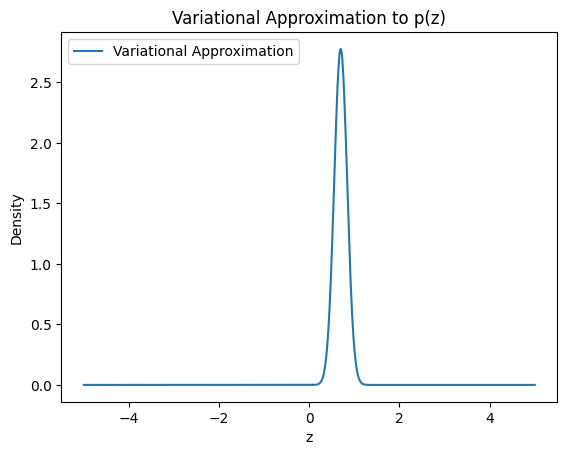

In [60]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import expit

# Function to compute the ELBO
def compute_elbo(mu, sigma_sq):
    # Compute the terms of the ELBO
    term1 = -0.5 * (mu**2 + sigma_sq)
    term2 = np.log(1 + np.exp(-(10 * mu + 3))) + np.maximum(0, (10 * mu + 3))
    return term1 + term2

# Function to update parameters in the M-step
def update_parameters(expected_z_sq, log_sigma_10z_3):
    # Update mu
    mu = 5 * (log_sigma_10z_3 - 3) / (1 + 100 * expected_z_sq)
    
    # Update sigma_sq
    sigma_sq = 1 / (1 + 100 * expected_z_sq)
    
    return mu, sigma_sq

# Initialize mu and sigma_sq for variational approximation
mu_var = 0
sigma_sq_var = 1

# Number of iterations for EM algorithm updates
num_iterations = 100
elbo_values = []

# EM algorithm updates for variational approximation
for i in range(num_iterations):
    # E-step
    expected_z_sq = mu_var**2 + sigma_sq_var
    log_sigma_10z_3 = np.log(1 + np.exp(-(10 * mu_var + 3))) + np.maximum(0, (10 * mu_var + 3))
    
    # M-step
    mu_var, sigma_sq_var = update_parameters(expected_z_sq, log_sigma_10z_3)
    
    # Compute and store ELBO
    elbo = compute_elbo(mu_var, sigma_sq_var)
    elbo_values.append(elbo)

# Generate points for plotting the density curve of the approximate distribution
z_values = np.linspace(-5, 5, 1000)
q_values = np.exp(-(z_values - mu_var)**2 / (2 * sigma_sq_var)) / np.sqrt(2 * np.pi * sigma_sq_var)

# Plot the density curve of the approximate distribution
plt.plot(z_values, q_values, label='Variational Approximation')

plt.xlabel('z')
plt.ylabel('Density')
plt.title('Variational Approximation to p(z)')
plt.legend()
plt.show()


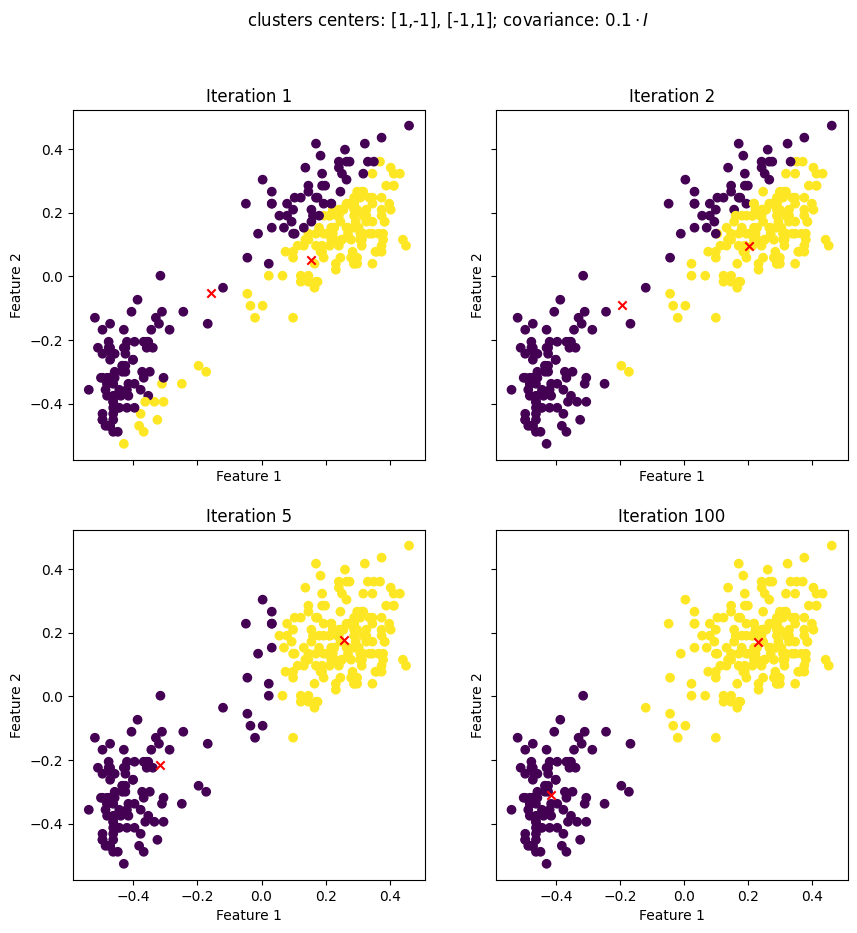

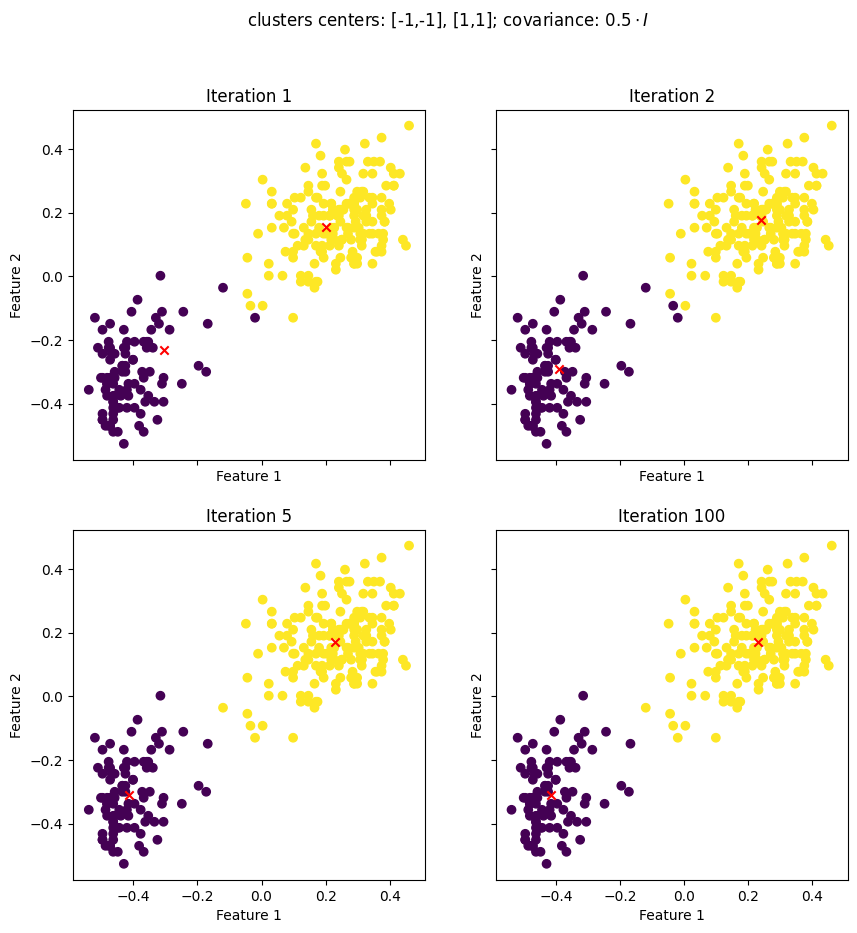

In [105]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

# Load data and normalize features
data = np.loadtxt("../data/faithful/faithful.txt")
data = (data - np.mean(data, axis=0)) / (np.max(data, axis=0) - np.min(data, axis=0))

# Implement EM algorithm for GMM
def initialize_parameters():
    # Initialize cluster centers and covariance matrices
    cluster_centers = np.array([[-1, 1], [1, -1]])
    covariance_matrices = np.array([0.1 * np.eye(2), 0.1 * np.eye(2)])
    return cluster_centers, covariance_matrices

def expectation_step(data, cluster_centers, covariance_matrices, weights):
    # Compute responsibilities
    responsibilities = np.zeros((len(data), len(cluster_centers)))
    for k in range(len(cluster_centers)):
        responsibilities[:, k] = weights[k] * multivariate_normal.pdf(data, mean=cluster_centers[k], cov=covariance_matrices[k])
    responsibilities /= np.sum(responsibilities, axis=1, keepdims=True)
    return responsibilities

def maximization_step(data, responsibilities):
    # Update cluster centers, covariance matrices, and weights
    N_k = np.sum(responsibilities, axis=0)
    cluster_centers = np.dot(responsibilities.T, data) / N_k[:, None]
    covariance_matrices = np.zeros((len(cluster_centers), data.shape[1], data.shape[1]))
    for k in range(len(cluster_centers)):
        diff = data - cluster_centers[k]
        covariance_matrices[k] = np.dot(responsibilities[:, k] * diff.T, diff) / N_k[k]
    weights = N_k / len(data)
    return cluster_centers, covariance_matrices, weights

def compute_log_likelihood(data, cluster_centers, covariance_matrices, weights):
    log_likelihood = 0
    for k in range(len(cluster_centers)):
        log_likelihood += np.sum(weights[k] * multivariate_normal.logpdf(data, mean=cluster_centers[k], cov=covariance_matrices[k]))
    return log_likelihood

def run_em_algorithm(data, cluster_centers, covariance_matrices, weights, iterations):
    log_likelihoods = []
    for i in range(iterations):
        # E-step
        responsibilities = expectation_step(data, cluster_centers, covariance_matrices, weights)
        # M-step
        cluster_centers, covariance_matrices, weights = maximization_step(data, responsibilities)
        # Compute log-likelihood
        log_likelihood = compute_log_likelihood(data, cluster_centers, covariance_matrices, weights)
        log_likelihoods.append(log_likelihood)
    return cluster_centers, covariance_matrices, weights, log_likelihoods

# Visualization function
def visualize_clusters(data, cluster_centers, responsibilities, title):
    plt.scatter(data[:, 0], data[:, 1], c=responsibilities.argmax(axis=1), cmap='viridis', alpha=0.5)
    plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], c='red', marker='x', label='Cluster Centers')
    plt.title(title)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.legend()
    plt.colorbar()
    plt.show()

# Part (a): Initialize cluster centers and covariance matrices
cluster_centers, covariance_matrices = initialize_parameters()
weights = np.ones(len(cluster_centers)) / len(cluster_centers)
iterations = 100


plot_loc = {1:[0,0], 2:[0,1], 5:[1,0], 100:[1,1]}
fig, ax = plt.subplots(2,2, sharex=True, sharey = True, figsize=(10,10))
for i in [1, 2, 5, 100]:
    cluster_centers, covariance_matrices, weights, _ = run_em_algorithm(data, cluster_centers, covariance_matrices, weights, i)
    responsibilities = expectation_step(data, cluster_centers, covariance_matrices, weights)
    ax[plot_loc[i][0], plot_loc[i][1]].scatter(data[:,0], data[:,1], c=responsibilities.argmax(axis=1), marker='o')
    ax[plot_loc[i][0], plot_loc[i][1]].scatter(cluster_centers[:,0], cluster_centers[:,1], c='red', marker='x')
    ax[plot_loc[i][0], plot_loc[i][1]].set_title('Iteration %s'%i)
    ax[plot_loc[i][0], plot_loc[i][1]].set_xlabel('Feature 1')
    ax[plot_loc[i][0], plot_loc[i][1]].set_ylabel('Feature 2')
    #visualize_clusters(data, cluster_centers, responsibilities, f"Iteration {i}")
fig.suptitle('clusters centers: [1,-1], [-1,1]; covariance: $0.1\cdot I$')
plt.show()

# Part (b): Initialize cluster centers and covariance matrices differently
cluster_centers, covariance_matrices = np.array([[-1, -1], [1, 1]]), np.array([0.5 * np.eye(2), 0.5 * np.eye(2)])
fig, ax = plt.subplots(2,2, sharex=True, sharey = True, figsize=(10,10))
for i in [1, 2, 5, 100]:
    cluster_centers, covariance_matrices, weights, _ = run_em_algorithm(data, cluster_centers, covariance_matrices, weights, i)
    responsibilities = expectation_step(data, cluster_centers, covariance_matrices, weights)
    ax[plot_loc[i][0], plot_loc[i][1]].scatter(data[:,0], data[:,1], c=responsibilities.argmax(axis=1), marker='o')
    ax[plot_loc[i][0], plot_loc[i][1]].scatter(cluster_centers[:,0], cluster_centers[:,1], c='red', marker='x')
    ax[plot_loc[i][0], plot_loc[i][1]].set_title('Iteration %s'%i)
    ax[plot_loc[i][0], plot_loc[i][1]].set_xlabel('Feature 1')
    ax[plot_loc[i][0], plot_loc[i][1]].set_ylabel('Feature 2')
    #visualize_clusters(data, cluster_centers, responsibilities, f"Iteration {i}")
fig.suptitle('clusters centers: [-1,-1], [1,1]; covariance: $0.5\cdot I$')
plt.show()